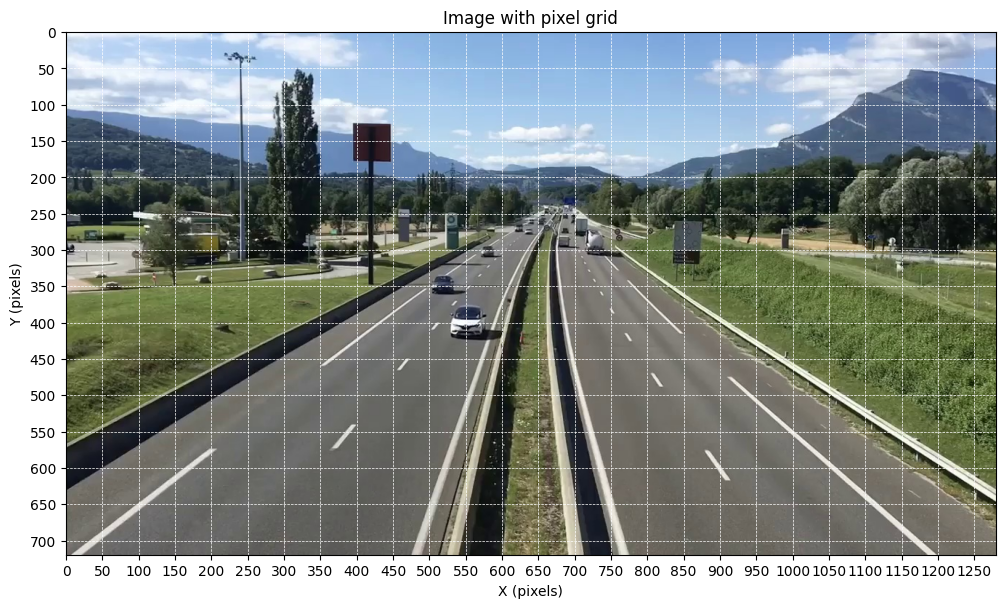

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Read the image and convert to RGB
img = Image.open("data/highway_frame.jpg").convert("RGB")
img_array = np.array(img)

# Plot the image
plt.figure(figsize=(12, 8))
plt.imshow(img_array)
plt.axis("on")  # Turn on the axis to show X and Y coordinates

# Set ticks every 50 pixels
plt.xticks(np.arange(0, img_array.shape[1], 50))
plt.yticks(np.arange(0, img_array.shape[0], 50))

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5)  # White dashed grid

# Add axis labels and title
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.title("Image with pixel grid")

# Display the plot
plt.show()

In [62]:
from ultralytics import YOLO

model = YOLO("model/yolov8l_car.pt")
results = model("data/car.jpg")

# results เป็น list ของ Results objects
r = results[0]

# 1. ดึง bounding boxes
boxes = r.boxes  # .xyxy, .xywh, .cls, .conf

# 2. ดึง coordinates
xyxy = boxes.xyxy.cpu().numpy()      # [x1, y1, x2, y2]
cls  = boxes.cls.cpu().numpy()       # class ids
conf = boxes.conf.cpu().numpy()      # confidence

# 3. ดึง object IDs (ถ้า track)
ids = boxes.id.int().cpu().numpy() if boxes.id is not None else None




image 1/1 c:\Project\code\KMITL-Workshop-yolo-car-counting\data\car.jpg: 384x640 1 car, 72.6ms
Speed: 2.9ms preprocess, 72.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


# Load pretrained YOLO model

In [34]:
from ultralytics import YOLO

# Load YOLOv8 pretrained model
model = YOLO("model\yolov8l_car.pt")  # small model for fast inference
model.info()

YOLOv8l summary: 209 layers, 43,691,520 parameters, 0 gradients, 165.7 GFLOPs


(209, 43691520, 0, 165.742848)

# Prepare video and image sample

In [57]:
# Using uploaded video
video_path = "data/highway.mp4"


# Run YOLO detection on one frame (exploration)

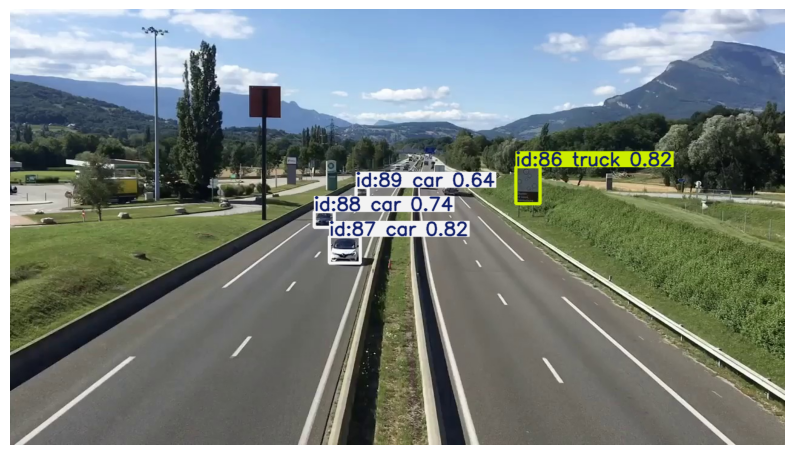

In [58]:
import cv2
import matplotlib.pyplot as plt

# Read image with OpenCV
image_path = "data/highway_frame.jpg"

# Read one frame
img = cv2.imread(image_path)

# Run YOLO detection (track=False for single frame)
results = model(img, conf=0.5)

# Display the frame with boxes
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


# Extract object centers

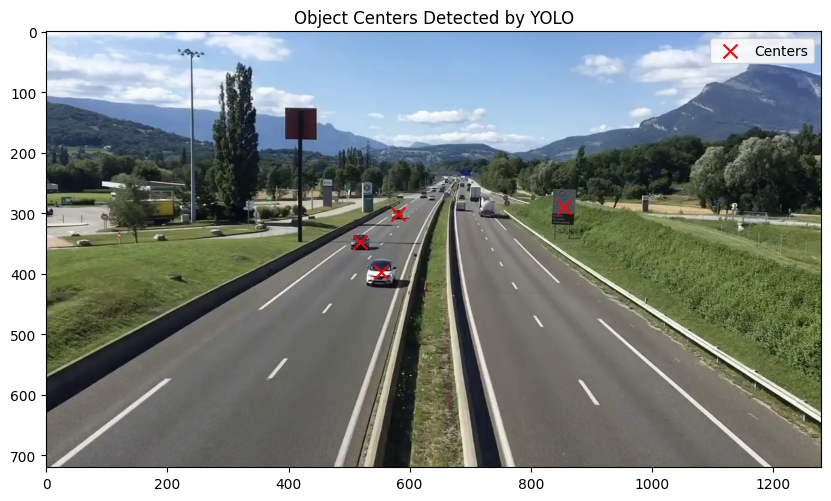

In [59]:
def get_object_centers(results):
    centers = []
    ids = []
    if results[0].boxes.id is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        ids = results[0].boxes.id.int().cpu().tolist()
        for box in boxes:
            x1, y1, x2, y2 = box
            cx, cy = int((x1 + x2)/2), int((y1 + y2)/2)
            centers.append((cx, cy))
    return centers, ids

centers, _ = get_object_centers(results)

# Plot centers on the image
plt.figure(figsize=(10,8))

# Convert BGR → RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis("on")

# Plot object centers
if centers:
    xs, ys = zip(*centers)
    # invert y-axis for matplotlib
    plt.scatter(xs, ys, c='red', s=100, marker='x', label='Centers', zorder=2)

plt.title("Object Centers Detected by YOLO")
plt.legend()
plt.show()

# Count vehicles crossing ROI line (video)

In [63]:
# ROI line (only a segment)
line_y = 500
line_x_start = 200  
line_x_end = 600

counted_ids = set()
total_count = 0

# Open video writer
cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("highway_counted.mp4", fourcc, fps, (width, height))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    results = model.track(frame, conf=0.5, persist=True, verbose=False)
    centers, ids = get_object_centers(results)
    
    # Count objects crossing ROI segment
    for (cx, cy), obj_id in zip(centers, ids):
        if line_y-5 < cy < line_y+5 and line_x_start <= cx <= line_x_end and obj_id not in counted_ids:
            counted_ids.add(obj_id)
            total_count += 1
    
    # Draw ROI segment and centers
    cv2.line(frame, (line_x_start, line_y), (line_x_end, line_y), (0,255,255), 2)
    for cx, cy in centers:
        cv2.circle(frame, (cx, cy), 4, (0,0,255), -1)
    cv2.putText(frame, f"Count: {total_count}", (20,40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    
    out.write(frame)

cap.release()
out.release()
print(f"Video saved to highway_counted.mp4")


Video saved to highway_counted.mp4


# Display counted video in Colab

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open("highway_counted.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=800 controls>
  <source src="{data_url}" type="video/mp4">
</video>